## Section 1. Parses all PCAP files

In [92]:
import dpkt
import time
import socket
import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
from multiprocessing import Pool

pd.options.display.float_format = '{:20.3f}'.format

### constants
g_dataDir = '../../iot_data/'
g_dataExtension = '.pcap'
g_testfile = '../../iot_data/16-09-27.pcap'
g_poolSize = 10
g_min_interval_seconds = 10
g_showprocess_count = 300000
g_timezone = 'AET' # They're in Sydney, Australia Eastern Time Zone
#columns = ['local_ip', 'local_port', 'remote_ip', 'remote_port', 'direction', 'len', 'seq', 'timestamp']
columns = ['len', 'timestamp']

### parse pcap files
def parsePcap(fileName):
    devices = {}
    file = open(fileName,'rb')
    for ts, pkt in dpkt.pcapng.Reader(file):
        eth = dpkt.ethernet.Ethernet(pkt)
        if eth.type != dpkt.ethernet.ETH_TYPE_IP:
            continue

        ip = eth.data
        if not hasattr(ip, 'p') or ip.p != dpkt.ip.IP_PROTO_TCP:
            continue

        # only tcp traffic is analyzed
        tcp = ip.data
        srcIp = socket.inet_ntoa(ip.src)
        dstIp = socket.inet_ntoa(ip.dst)
        if srcIp.startswith('192.168.'):
            localIp = srcIp
            localPort = tcp.sport
            remoteIp = dstIp
            remotePort = tcp.dport
            direction = 'out'
        else:
            localIp = dstIp
            localPort = tcp.dport
            remoteIp = srcIp
            remotePort = tcp.sport
            direction = 'in'

        # check if dataframe is created for this ip
        if localIp not in devices:
            devices[localIp] = {}

        # save data to corresponding device's dataframe
        section = math.floor(ts / g_min_interval_seconds) * g_min_interval_seconds
        if section not in devices[localIp]:
            devices[localIp][section] = 0
        devices[localIp][section] += len(tcp.data) / 1024
        # df.loc[df.shape[0]] = [localIp, localPort, remoteIp, remotePort, direction, len(tcp.data), tcp.seq, ts]
        
    print('Finished parsing: ' + fileName + '\n')
    return devices

def mergeDevice(d1, d2):
    for ts, n in d2.items():
        if ts not in d1:
            d1[ts] = n
        else:
            d1[ts] += n
    
    
### list files
dataFiles = []
for fileName in os.listdir(g_dataDir):
    if fileName.endswith(g_dataExtension):
        dataFiles.append(os.path.join(g_dataDir, fileName))

### send job to workers
pool = Pool(g_poolSize)
devicesArray = pool.map(parsePcap, dataFiles)

### merge results
devices = {}
for d in devicesArray:
    for key, value in d.items():
        if key not in devices:
            devices[key] = value
        else:
            mergeDevice(devices[key], value)

print("Parse completed for all files")


Finished parsing: ../../iot_data/16-09-25.pcap


Finished parsing: ../../iot_data/16-09-26.pcap


Finished parsing: ../../iot_data/16-10-08.pcap


Finished parsing: ../../iot_data/16-10-02.pcap


Finished parsing: ../../iot_data/16-09-29.pcap


Finished parsing: ../../iot_data/16-09-30.pcap


Finished parsing: ../../iot_data/16-09-24.pcap


Finished parsing: ../../iot_data/16-09-27.pcap


Finished parsing: ../../iot_data/16-10-06.pcap


Finished parsing: ../../iot_data/16-10-03.pcap


Finished parsing: ../../iot_data/16-10-09.pcap


Finished parsing: ../../iot_data/16-10-01.pcap


Finished parsing: ../../iot_data/16-10-07.pcap


Finished parsing: ../../iot_data/16-10-10.pcap


Finished parsing: ../../iot_data/16-09-23.pcap


Finished parsing: ../../iot_data/16-10-11.pcap


Finished parsing: ../../iot_data/16-10-05.pcap


Finished parsing: ../../iot_data/16-09-28.pcap


Finished parsing: ../../iot_data/16-10-04.pcap


Finished parsing: ../../iot_data/16-10-12.pcap


Parse completed for 

## Section 2. Plot data

/home/liangdong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=24583790.0, right=24583790.0
  ax.set_xlim(left, right)
/home/liangdong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=24603945.0, right=24603945.0
  ax.set_xlim(left, right)


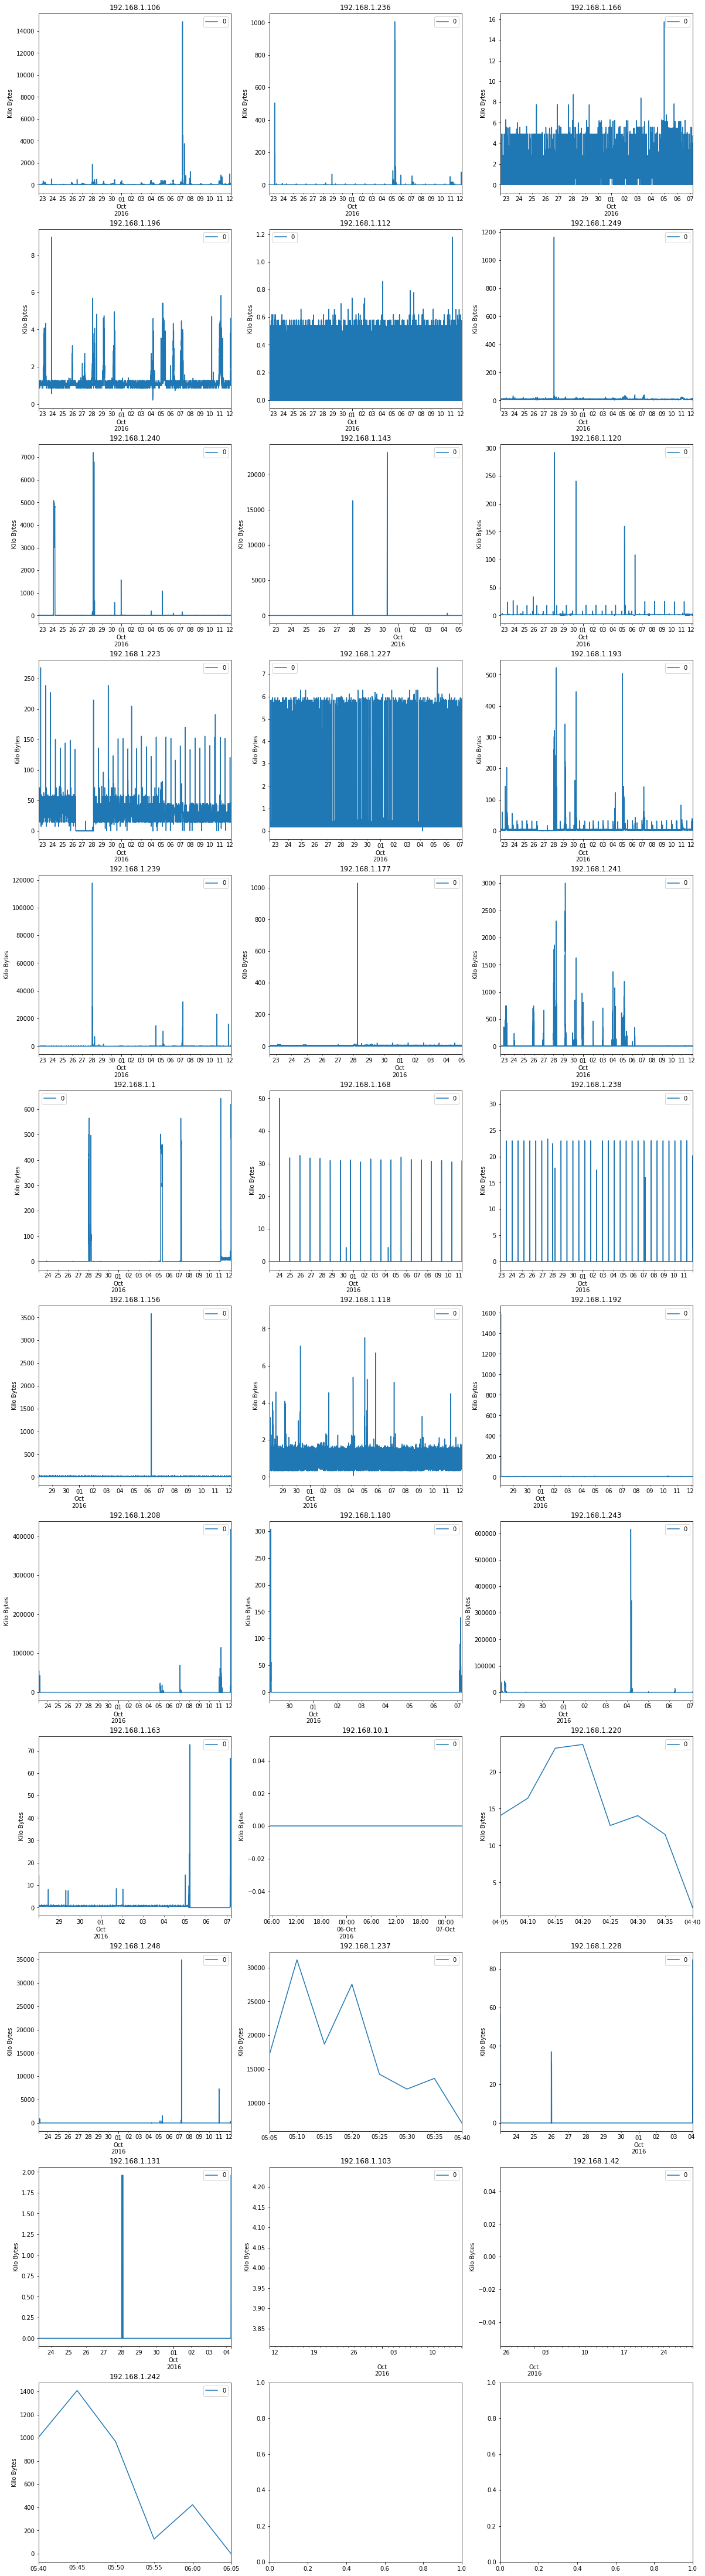

In [93]:
g_plot_freq = '5Min'
g_plot_columns = 3   # 3 sub plots per row

rowCount = math.ceil(len(devices)/g_plot_columns)
colCount = g_plot_columns
fig, axes = plt.subplots(nrows=rowCount, ncols=colCount, figsize=(20, 20 * rowCount / colCount))
plotIndex = 0
for key, value in devices.items():
    df = pd.DataFrame.from_dict(value, orient='index')
    df.index = pd.to_datetime(df.index, unit='s')
    df2 = df.groupby(pd.Grouper(freq=g_plot_freq)).sum()
    ax = df2.plot(title=key, ax=axes[math.floor(plotIndex / g_plot_columns), plotIndex % g_plot_columns])
    ax.set_ylabel("Kilo Bytes")
    plotIndex += 1
    